# 3D Image Reconstruction and Analysis in Medicine Project 2

Authors: Federica Aresu, Blanca Cabrera Gil

### Import Libraries

In [1]:
#Importing packages and libraries

from __future__ import print_function
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sp
import skimage as sk
from skimage import morphology
from scipy.misc import imsave
from ipywidgets import interact, fixed
import SimpleITK as sitk
from skimage import transform
import sys
#from Insight Software Consortium Github
sys.path.append('./L3.3_utilities')
import registration_utilities as ru
import registration_callbacks as rc

%run ./L3.3_utilities/popi_utilities_setup.py

In [2]:
#setting directory parameters
common_directory = 'COMMON_images_masks'
group_directory = 'GROUP_images-selected'
general_directory = '/3D-Project2'
mask_directory = '/registered_masks'

### Load Images

In [3]:
# Group images

def load_group_images(n):
    
    if n == 0:
        imgg = sitk.ReadImage(group_directory +'/g12_86_image.nii', sitk.sitkFloat32)
    elif n == 1:
        imgg = sitk.ReadImage(group_directory +'/g12_87_image.nii', sitk.sitkFloat32)
    elif n == 2:
        imgg = sitk.ReadImage(group_directory +'/g12_88_image.nii', sitk.sitkFloat32)
    else:
        print('Wrong number of images')
    
    return imgg

# Group Masks

def load_group_masks(n):
        
    if n == 0:
        maskg = sitk.ReadImage(group_directory +'/g12_86_image_mask.nii', sitk.sitkFloat32)
    elif n == 1:
        maskg = sitk.ReadImage(group_directory +'/g12_87_image_mask.nii', sitk.sitkFloat32)
    elif n == 2:
        maskg = sitk.ReadImage(group_directory +'/g12_88_image_mask.nii', sitk.sitkFloat32)
    else:
        print('Wrong number of images')
    
    return maskg


# Common images

def load_common_images(n):

    if n == 0:
        imgc = sitk.ReadImage(common_directory +'/common_40_image.nii', sitk.sitkFloat32)
    elif n == 1:
        imgc = sitk.ReadImage(common_directory +'/common_41_image.nii', sitk.sitkFloat32)
    elif n == 2:
        imgc = sitk.ReadImage(common_directory+'/common_42_image.nii', sitk.sitkFloat32)
    else:
        print('Wrong number of images')

    return imgc
    
# Common Masks

def load_common_masks(n):
        
    if n == 0:
        maskc = sitk.ReadImage(common_directory +'/common_40_mask.nii', sitk.sitkFloat32)
    elif n == 1:
        maskc = sitk.ReadImage(common_directory +'/common_41_mask.nii', sitk.sitkFloat32)
    elif n == 2:
        maskc = sitk.ReadImage(common_directory +'/common_43_mask.nii', sitk.sitkFloat32)
    else: 
        print('Wrong number of images')

    
    return maskc

# Group bonus masks

def load_masks_bonus(n):
        
    if n == 0:
        maskc = sitk.ReadImage(group_directory +'/g12_86_image_bonus_mask.nii', sitk.sitkFloat32)
    elif n == 1:
        maskc = sitk.ReadImage(group_directory +'/g12_87_image_bonus_mask.nii', sitk.sitkFloat32)
    elif n == 2:
        maskc = sitk.ReadImage(group_directory +'/g12_88_image_bonus_mask.nii', sitk.sitkFloat32)
    else: 
        print('Wrong number of images')

    
    return maskc




### Plot Methods

In [4]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()

    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]

        # the the number of components is 3 or 4 consider it an RGB image
        if c not in (3, 4):
            nda = nda[nda.shape[0] // 2, :, :]

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if c not in (3, 4):
            raise RuntimeError("Unable to show 3D-vector Image")

        # take a z-slice
        nda = nda[nda.shape[0] // 2, :, :, :]

    xsize = nda.shape[1]
    ysize = nda.shape[0]

    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * xsize / dpi, (1 + margin) * ysize / dpi

    plt.figure(figsize=figsize, dpi=dpi, tight_layout=True)
    ax = plt.gca()

    extent = (0, xsize * spacing[0], ysize * spacing[1], 0)

    t = ax.imshow(nda, extent=extent, interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")

    if(title):
        plt.title(title)

    plt.show()


In [5]:
#Display 3d images

def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    size = img.GetSize()
    img_xslices = [img[s,:,:] for s in xslices]
    img_yslices = [img[:,s,:] for s in yslices]
    img_zslices = [img[:,:,s] for s in zslices]
    
    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))
    
        
    img_null = sitk.Image([0,0], img.GetPixelIDValue(), img.GetNumberOfComponentsPerPixel())
    
    img_slices = []
    d = 0
    
    if len(img_xslices):
        img_slices += img_xslices + [img_null]*(maxlen-len(img_xslices))
        d += 1
        
    if len(img_yslices):
        img_slices += img_yslices + [img_null]*(maxlen-len(img_yslices))
        d += 1
     
    if len(img_zslices):
        img_slices += img_zslices + [img_null]*(maxlen-len(img_zslices))
        d +=1
    
    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen,d])
       
        else:
            img_comps = []
            for i in range(0,img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen,d]))
            img = sitk.Compose(img_comps)
            
    
    myshow(img, title, margin, dpi)

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


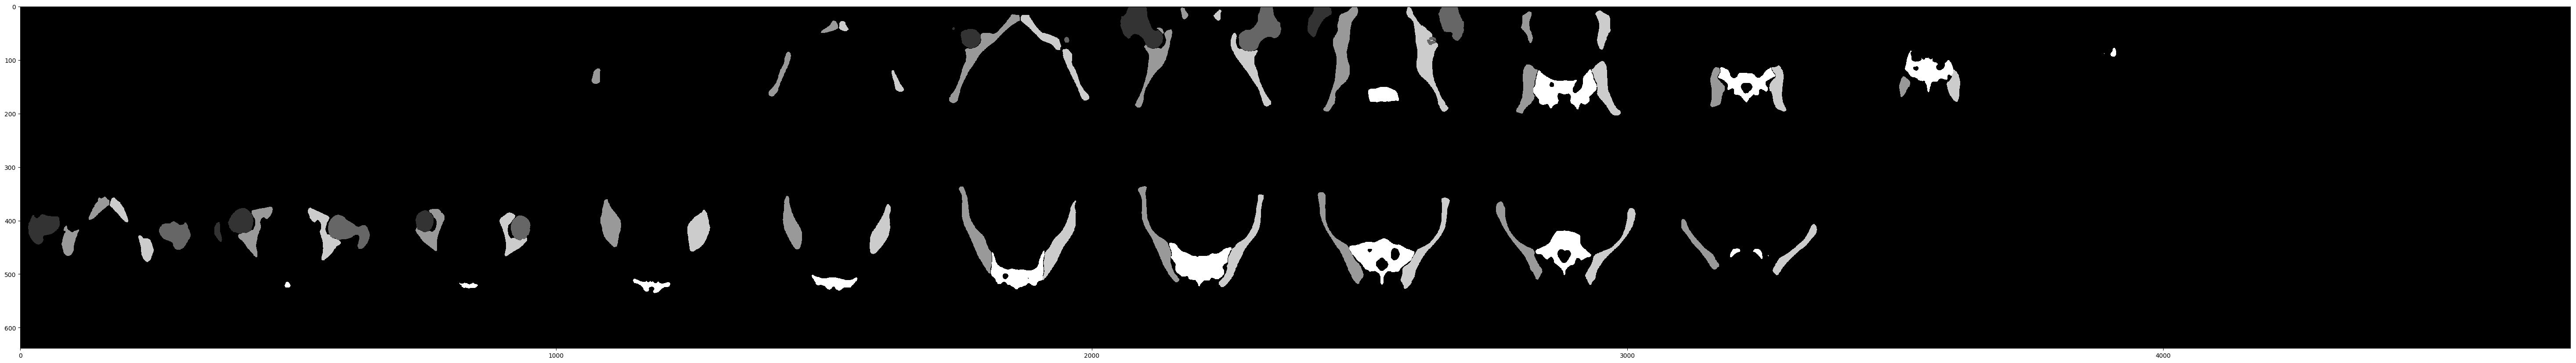

In [6]:
common = load_common_masks(0)
size = common.GetSize()
myshow3d(common, yslices=range(50, size[1] - 50, 30),zslices=range(50, size[2] - 50, 20), dpi=100)
   

### Registration Functions

#### Linear Registration: Affine Registration

In [ ]:
#Estimation of linear transformation using affine registration

def est_l_transf(fixed_image, moving_image, moving_mask):

    # Declare fixed and moving images
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_image)
    elastixImageFilter.SetMovingImage(moving_image)
    
    # Define parameter map
    affineParameterMap = sitk.GetDefaultParameterMap("affine")
    affineParameterMap['MaximumNumberOfIterations'] = ['1000']
    
    # Estimate transformation
    elastixImageFilter.SetParameterMap(affineParameterMap)
    elastixImageFilter.Execute()
    
    # Get transfomration
    transformParameterMap = elastixImageFilter.GetTransformParameterMap()[0]
    transformParameterMap['ResampleInterpolator'] = ['FinalNearestNeighborInterpolator']
    print('linear transform estimated')
    return transformParameterMap


In [ ]:
#Apply linear transformation for registration

def apply_l_transf(moving_image, transformation):
    
    # Apply transformation
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetTransformParameterMap(transformation)
    transformixImageFilter.SetMovingImage(moving_image)
    resultMImage = transformixImageFilter.Execute()
    resultMaskImage = sitk.Cast(resultMImage, sitk.sitkInt32)
    
    # Print results
    print('final linear transform')
    size = moving_image.GetSize()
    myshow3d(resultMaskImage, yslices=range(50, size[1] - 50, 30),zslices=range(50, size[2] - 50, 20), dpi=100)
    return resultMaskImage
    

#### Non-Linear Registration: Free Form Deformation

In [ ]:
#Estimation of Free Form Deformation using B-splines

def est_nl_transf(fixed_image, moving_image, fixed_image_mask=None, fixed_points=None, moving_points=None):

    # Declare fixed and moving images
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_image)
    elastixImageFilter.SetMovingImage(moving_image)

    # Create parameter map
    parameterMapVector = sitk.VectorOfParameterMap()
    parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
    parameterMapBspline =sitk.GetDefaultParameterMap("bspline")
    parameterMapBspline['MaximumNumberOfIterations'] = ['1000']
    parameterMapVector.append(parameterMapBspline)
   
    # Estimate the transformation
    elastixImageFilter.SetParameterMap(parameterMapVector)
    elastixImageFilter.Execute()

    print('execution passed!')
    
    # Get parameter map
    transformParameterMap = elastixImageFilter.GetTransformParameterMap()[0]
    transformParameterMap['ResampleInterpolator'] = ['FinalNearestNeighborInterpolator']  
    
    print('Non-linear transform estimated')

    return transformParameterMap

In [ ]:
#Application of the non-linear transformation
def apply_nl_transf(moving, transformation):
    
    # Apply transformation
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetTransformParameterMap(transformation)
    transformixImageFilter.SetMovingImage(moving)
    resultMImage = transformixImageFilter.Execute()
    resultMaskImage = sitk.Cast(resultMImage, sitk.sitkInt32)
    registered_mask = transformixImageFilter.GetResultImage()

    print('Non-linear transform applied')
    
    return registered_mask


### Atlas-Based Segmentation

In [ ]:
def majority_vote(c,label,name_file, name_save):
    
    new_common_mask = []
    
    new_group_masks = []
    
    print('Preparing for majority vote {0} label {1}'.format(c, label))
        
    # Loop for the three images for the multi-atlas creation
    for index in range(0,3):
        image_original = sitk.GetImageFromArray(sitk.GetArrayFromImage(sitk.ReadImage(name_file.format(c,index)) == label)*1)
         
        # Perform Dilation
        filter_d = sitk.GrayscaleDilateImageFilter()
        image_d = filter_d.Execute(image_original)
        
        # Perform Closing
        image= sitk.GetImageFromArray(sk.morphology.closing(sitk.GetArrayFromImage(image_d)))
        image.SetOrigin(origin)
        new_group_masks.append(sitk.Cast(image, sitk.sitkUInt8))

    # Majority voting of labels
    labelForUndecidedPixels = label
    new_mask = sitk.LabelVoting(new_group_masks, labelForUndecidedPixels)

    print('Majority vote {0} label {1} DONE'.format(c,label))

    # Save obtained majority voted common mask
    sitk.WriteImage(new_mask, name_save.format(c,label))
    
    # Plot result
    size = new_mask.GetSize()
    print('Majority vote mask {0} label {1}'.format(c, label))
    myshow3d(new_mask, yslices=range(50, size[1] - 50, 30), zslices=range(50, size[2] - 50, 20), dpi=100)
    
             
    return new_mask


In [ ]:
## Atlas Segmentation function
def seg_atlas(fixed_images_number, moving_images_number):    
  
    new_common_mask = []
    
    for c in range(fixed_images_number):
        
        fixed = load_common_images(c)
        
        new_group_masks = []
    
        for g in range(moving_images_number):
            
            # Load fixed and moving images and moving mask
            moving = load_group_images(g)
            
            moving_mask = load_group_masks(g)
            
            moving_mask_bonus = load_masks_bonus(g)
            
            # Set the right origin to the functions
            origin = fixed.GetOrigin()
            moving.SetOrigin(origin)
            moving_mask.SetOrigin(origin)
            moving_mask_bonus.SetOrigin(origin)

            
            #Estimate linear transformation between the group and common images
            tx_linear = est_l_transf(fixed, moving, moving_mask)
            
        
            #Apply the linear transformation to the group mask and to the corresponding group image
            registerd_LINEAR_mask = apply_l_transf(moving_mask, tx_linear)
            
            registerd_LINEAR_mask_bonus = apply_l_transf(moving_mask_bonus, tx_linear)
            
            sitk.WriteImage(registerd_LINEAR_mask, 'registered_mask_common{0}_moving{1}.nii'.format(c,g))
            
            registered_moving_image = apply_l_transf(moving, tx_linear)
        

            #Estimate the non-linear transformation between the group and common images - 1st
            tx_non_linear = est_nl_transf(fixed_image = fixed, moving_image = registered_moving_image)


            #Apply the non-linear transformation to the mask of the group images - 1st
            registered_mask1 = apply_nl_transf(registerd_LINEAR_mask, tx_non_linear)
            
            registered_mask1_bonus = apply_nl_transf(registerd_LINEAR_mask_bonus, tx_non_linear)
            
            registered_nonlinear_image = apply_nl_transf(registered_moving_image, tx_non_linear)
            
            #Estimate the non-linear transformation between the group and common images - 2nd
            tx_non_linear = est_nl_transf(fixed_image = fixed, moving_image = registered_nonlinear_image)


            #Apply the non-linear transformation to the mask of the group images - 2nd
            registered_mask = apply_nl_transf(registered_mask1, tx_non_linear)
            
            registered_mask_bonus = apply_nl_transf(registered_mask1_bonus, tx_non_linear)
            
            
            # Save obtained registered mask
            sitk.WriteImage(registered_mask, 'registered_mask_common{0}_moving{1}.nii'.format(c,g))
            
            sitk.WriteImage(registered_mask_bonus, 'registered_mask_common{0}_moving{1}_bonus.nii'.format(c,g))
            
            # Plot results
            size = registered_mask.GetSize()
            print('registered image')
            myshow3d(registered_mask, yslices=range(50, size[1] - 50, 30), zslices=range(50, size[2] - 50, 20), dpi=100)
            print('common mask')
            fixed_mask = load_common_masks(c)
            myshow3d(fixed_mask, yslices=range(50, size[1] - 50, 30), zslices=range(50, size[2] - 50, 20), dpi=100)
            
            print('Bonus image')
            size = registered_mask_bonus.GetSize()
            print('registered image')
            myshow3d(registered_mask_bonus, yslices=range(50, size[1] - 50, 30), zslices=range(50, size[2] - 50, 20), dpi=100)
            print('common mask')
            fixed_mask = load_common_masks(c)
            myshow3d(fixed_mask, yslices=range(50, size[1] - 50, 30), zslices=range(50, size[2] - 50, 20), dpi=100)
            
            # Free memory space
            moving = None
            moving_mask = None
            fixed_mask = None
            registere_mask = None
            
            
            
    return 
        

#### Perform Atlas-Based Segmentation

In [ ]:
# Perform Atlas-Based Segmentation (All Bones)

seg_atlas(3, 3)


In [ ]:
# Majority voting Right bones

name_file = 'registered_mask_common{0}_moving{1}.nii'
name_save = 'majority_voted_mask{0}_label{1}.nii'
for c in range(3):
    for label in range(1,3):
        majority_voted_mask = majority_vote(c,label,name_file, name_save)

In [ ]:
# Majority voting Bonus

name_file = 'registered_mask_common{0}_moving{0}_bonus.nii'
name_save = 'majority_voted_mask{0}_label{1}_bonus.nii'

for c in range(3):
    for label in range(1,4):
        majority_voted_mask = majority_vote(c,label, name_file, name_save)

### Accuracy Assesment

In [ ]:
# Accuracy assessment

# Compute the Dice coefficient and Hausdorff distance between the segmentations before, and after registration.
for i in range(3):
    
    ## Right Femur
    ground_truth = sitk.GetImageFromArray((sitk.GetArrayFromImage(load_common_masks(i)) == 1)*1)
    after_registration_1 = sitk.ReadImage('majority_voted_mask{0}_label1.nii'.format(i), sitk.sitkFloat32)
   
    # Apply closing
    after_registration = sitk.GetImageFromArray(sp.ndimage.morphology.binary_closing(sitk.GetArrayFromImage(after_registration_1).astype(bool),iterations=10)*1)

    # Plot Comparison 
    plt.figure()
    plt.imshow(sitk.GetArrayFromImage(ground_truth)[:,200,:],cmap='gray')
    plt.title('Ground Truth')
    plt.show()
    plt.imshow(sitk.GetArrayFromImage(after_registration)[:,200,:],cmap='gray')
    plt.title('After Closing')
    plt.show()

    # Measure Dice Coefficient
    label_overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    label_overlap_measures_filter.Execute(ground_truth, after_registration)
    print("Dice coefficient of hip {} after registration of mask {:.2f}".format(i,label_overlap_measures_filter.GetDiceCoefficient()))

    # Measure Housdorff Distance
    hausdorff_distance_image_filter = sitk.HausdorffDistanceImageFilter()
    hausdorff_distance_image_filter.Execute(ground_truth, after_registration)
    print("Hausdorff distance of hip {} after registration of mask {:.2f}".format(i,hausdorff_distance_image_filter.GetHausdorffDistance()))

    ## Right Hip
    ground_truth = sitk.GetImageFromArray((sitk.GetArrayFromImage(load_common_masks(i)) == 3)*1)
    after_registration_2 = sitk.ReadImage('majority_voted_mask{0}_label2.nii'.format(i), sitk.sitkFloat32)
    # Apply Closing
    after_registration_3 = sitk.GetImageFromArray(sp.ndimage.morphology.binary_closing(sitk.GetArrayFromImage(after_registration_2).astype(bool),iterations=10)*1)

    # Plot Comparison
    plt.figure()
    plt.imshow(sitk.GetArrayFromImage(ground_truth)[:,200,:],cmap='gray')
    plt.title('Ground Truth')
    plt.show()
    plt.imshow(sitk.GetArrayFromImage(after_registration_3)[:,200,:],cmap='gray')
    plt.title('After Closing')
    plt.show()

    # Compute Dice Coefficient
    label_overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    label_overlap_measures_filter.Execute(ground_truth, after_registration_3)
    print("Dice coefficient of femur after registrationof mask {}: {:.2f}".format(i,label_overlap_measures_filter.GetDiceCoefficient()))

    # Compute Housdorff Distance
    hausdorff_distance_image_filter = sitk.HausdorffDistanceImageFilter()
    hausdorff_distance_image_filter.Execute(ground_truth, after_registration_3)
    print("Hausdorff distance of femur after registration of mask {}: {:.2f}".format(i, hausdorff_distance_image_filter.GetHausdorffDistance()))

In [ ]:
# Accuracy assesment - BONUS PART

# Compute the Dice coefficient and Hausdorff distance between the segmentations after registration.
for i in range(3):
    
    ## Sacrum
    ground_truth = sitk.GetImageFromArray((sitk.GetArrayFromImage(load_common_masks(i)) == 5)*1)
    after_registration_5 = sitk.ReadImage('majority_voted_mask{0}_label3_bonus.nii'.format(i), sitk.sitkFloat32)
    # Apply Closing
    after_registration = sitk.GetImageFromArray(sp.ndimage.morphology.binary_closing(sitk.GetArrayFromImage(after_registration_5).astype(bool),iterations=10)*1)

    # Plot the comparison
    plt.figure()
    plt.imshow(sitk.GetArrayFromImage(ground_truth)[:,150,:],cmap='gray')
    plt.title('Ground Truth')
    plt.show()
    plt.imshow(sitk.GetArrayFromImage(after_registration)[:,150,:],cmap='gray')
    plt.title('After Closing')
    plt.show()

    # Compute Dice Coefficient
    label_overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    label_overlap_measures_filter.Execute(ground_truth, after_registration)
    print("Dice coefficient of Sacrum {} after registration of mask {:.2f}".format(i,label_overlap_measures_filter.GetDiceCoefficient()))
    # Compute Hausdorff Distance
    hausdorff_distance_image_filter = sitk.HausdorffDistanceImageFilter()
    hausdorff_distance_image_filter.Execute(ground_truth, after_registration)
    print("Hausdorff distance of Sacrum {} after registration of mask {:.2f}".format(i,hausdorff_distance_image_filter.GetHausdorffDistance()))


    ## Left femur
    ground_truth = sitk.GetImageFromArray((sitk.GetArrayFromImage(load_common_masks(i)) == 2)*1)
    after_registration_1 = sitk.ReadImage('majority_voted_mask{0}_label2_bonus.nii'.format(i), sitk.sitkFloat32)
    
    # Perform Closing
    after_registration = sitk.GetImageFromArray(sp.ndimage.morphology.binary_closing(sitk.GetArrayFromImage(after_registration_1).astype(bool),iterations=10)*1)

    # Plot Comparison
    plt.figure()
    plt.imshow(sitk.GetArrayFromImage(ground_truth)[:,200,:],cmap='gray')
    plt.title('Ground Truth')
    plt.show()
    plt.imshow(sitk.GetArrayFromImage(after_registration)[:,200,:],cmap='gray')
    plt.title('After Closing')
    plt.show()

    # Compute Dice Coefficient
    label_overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    label_overlap_measures_filter.Execute(ground_truth, after_registration)
    print("Dice coefficient of hip {} after registration of mask {:.2f}".format(i,label_overlap_measures_filter.GetDiceCoefficient()))
    # Compute Hausdorff
    hausdorff_distance_image_filter = sitk.HausdorffDistanceImageFilter()
    hausdorff_distance_image_filter.Execute(ground_truth, after_registration)
    print("Hausdorff distance of hip {} after registration of mask {:.2f}".format(i,hausdorff_distance_image_filter.GetHausdorffDistance()))

    # left hip
    ground_truth = sitk.GetImageFromArray((sitk.GetArrayFromImage(load_common_masks(i)) == 4)*1)
    after_registration_2 = sitk.ReadImage('majority_voted_mask{0}_label1_bonus.nii'.format(i), sitk.sitkFloat32)
    # Perform Closing and Erosion
    after_registration_3 = sitk.GetImageFromArray(sp.ndimage.morphology.binary_closing(sitk.GetArrayFromImage(after_registration_2).astype(bool),iterations=10)*1)
    after_registration_4_1 = sitk.GetImageFromArray(sk.morphology.erosion(sitk.GetArrayFromImage(after_registration_3)))
    after_registration_4 = sitk.GetImageFromArray(sk.morphology.erosion(sitk.GetArrayFromImage(after_registration_4_1)))

    # Plot Comparison
    plt.figure()
    plt.imshow(sitk.GetArrayFromImage(ground_truth)[:,200,:],cmap='gray')
    plt.title('Ground Truth')
    plt.show()
    plt.imshow(sitk.GetArrayFromImage(after_registration_4)[:,200,:],cmap='gray')
    plt.title('After Closing')
    plt.show()

    # Compute Dice Coefficient
    label_overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    label_overlap_measures_filter.Execute(ground_truth, after_registration_4)
    print("Dice coefficient of femur after registrationof mask {}: {:.2f}".format(i,label_overlap_measures_filter.GetDiceCoefficient()))
    # Compute Hausdorff Distance
    hausdorff_distance_image_filter = sitk.HausdorffDistanceImageFilter()
    hausdorff_distance_image_filter.Execute(ground_truth, after_registration_4)
    print("Hausdorff distance of femur after registration of mask {}: {:.2f}".format(i, hausdorff_distance_image_filter.GetHausdorffDistance()))

# Classifier

### Dataset creation for image classification

In [ ]:
# Load images
imgg1 = sitk.GetArrayFromImage(sitk.ReadImage(group_directory +'/g12_86_image.nii', sitk.sitkFloat32))
imgg2 = sitk.GetArrayFromImage(sitk.ReadImage(group_directory +'/g12_87_image.nii', sitk.sitkFloat32))
imgg3 = sitk.GetArrayFromImage(sitk.ReadImage(group_directory +'/g12_88_image.nii', sitk.sitkFloat32))
imgc1 = sitk.GetArrayFromImage(sitk.ReadImage(common_directory +'/common_40_image.nii', sitk.sitkFloat32))
imgc2 = sitk.GetArrayFromImage(sitk.ReadImage(common_directory +'/common_41_image.nii', sitk.sitkFloat32))
imgc3 = sitk.GetArrayFromImage(sitk.ReadImage(common_directory+'/common_42_image.nii', sitk.sitkFloat32))
print('Images loaded')

In [ ]:
# Common data 
n_common = []
X_common = []

for i in range(imgc1.shape[0]):
    if i < 21:
        n_common.append(0)
    elif i >= 21 and i <= 51:
        n_common.append(1)
    elif i > 51:
        n_common.append(0)
    X_common.append(imgc1[i])

for i in range(imgc2.shape[0]):
    if i < 43:
        n_common.append(0)
    elif i >= 43 and i <= 66:
        n_common.append(1)
    elif i > 66:
        n_common.append(0)
    X_common.append(imgc2[i])

for i in range(imgc3.shape[0]):
    if i < 21:
        n_common.append(0)
    elif i >= 21 and i <= 50:
        n_common.append(1)
    elif i > 50:
        n_common.append(0)
    X_common.append(imgc3[i])


In [ ]:
# Group data

n_imgg = []
X_group = []

for i in range(0, imgg2.shape[0], 1):

    if i <= 84:
        n_imgg.append(0)
    if i > 84:
        if i <= 108:
            n_imgg.append(1)
    if i > 108:
        n_imgg.append(0)

    X_group.append(imgg2[i])

for i in range(0, 245, 1):

    if i <= 55:
        n_imgg.append(0)
    if i > 55:
        if i <= 78:
            n_imgg.append(1)
    if i > 78:
        n_imgg.append(0)

    X_group.append(imgg1[i])

for i in range(0, imgg3.shape[0], 1):

    if i <= 77:
        n_imgg.append(0)
    if i > 77:
        if i <= 102:
            n_imgg.append(1)
    if i > 102:
        n_imgg.append(0)

    X_group.append(imgg3[i])
print('Database created')

In [ ]:
# Reduce the image size
print('Performing conversions and downsamplings')
X_group = np.asarray(X_group)
X_common = np.asarray(X_common)
n_imgg = np.asarray(n_imgg)
n_common = np.asarray(n_common)

print(X_group.shape)
print(type(n_imgg))

# Downscale the images
X_groupD = transform.downscale_local_mean(X_group, (1, 4,4))
X_commonD = transform.downscale_local_mean(X_common, (1,4,4))

plt.figure()
plt.imshow(X_groupD[1,:,:])
plt.title('Downsampled image', cmap = 'gray')
plt.show()
print(X_groupD.shape)
print(X_commonD.shape)

In [ ]:
# Flatten the images to 2D
X_groupD_flat = X_groupD.reshape(X_groupD.shape[0],X_groupD.shape[1]*X_groupD.shape[2])
print(X_groupD_flat.shape)
X_commonD_flat = X_commonD.reshape(X_commonD.shape[0],X_commonD.shape[1]*X_commonD.shape[2])
print(X_commonD_flat.shape)

### Classifier

In [ ]:
# K-Neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

neigh = KNeighborsClassifier(n_neighbors=20,weights='distance')
y_pred = neigh.fit(X_groupD_flat, n_imgg).predict(X_commonD_flat)


In [ ]:
# Take model metrix
accuracy = neigh.score(X_commonD_flat, n_common)
print('The accuracy of the model on the test data is: ', accuracy)

In [ ]:
# Slice with higher accuarcy
common_probabilities = neigh.predict_proba(X_commonD_flat)
highest_score = np.argmax(common_probabilities)

print('Slice with higest accuracy: ', highest_score)

# Print slice with higher probability
plt.figure()
plt.imshow(X_common[highest_score,:,:], cmap='gray')
plt.title('Slice with higher probability')
plt.show()